# Question 2:
## How much money do people in Berlin earn with their Airbnb homes?

The second question around the Airbnb Berlin data set is about the __amount of money that Airbnb home owners earn__ with their listings. There are __multiple factors__ that have an influence on the income of a single Airbnb listing. On the one hand it's a listing's __price including extra fees__ for additional people. On the other hand it's the __number of nights__ that an Airbnb home is booked. As the data set at hand doesn't include any information on booking histories we need to come up with an __approximation__ for these variables in order to be able to answer to underlying question of this analysis.

To __simplify the analysis__, the approximation of an Airbnb listing's (minimum) income will be based on a:
* Listing __price__ without additional guests
* Booking duration equal to the __minimum number of nights__
* Booking frequency equal to the __number of reviews per month__

The __steps__ involved in answering the question are as follows:
* Load Libraries
* Import Data Set
* Pre-Processing
* Analyze Data Set & Evaluate Results

## Load Libraries

In [477]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import folium

%matplotlib inline

## Import Data Set

In [478]:
# Import listings data
# Source: http://insideairbnb.com/get-the-data.html
df_listings = pd.read_csv('/Users/patrick.peltier/Documents/Udacity Data Science Nanodegree/Data/Airbnb/listings_berlin.csv')

# Preview data
print(df_listings.shape)
pd.options.display.max_columns = None
df_listings.head(1)

(22572, 96)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20180912025131,2018-09-12,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,"This is my home, not a hotel. I rent out occas...","Close to U-Bahn U8 and U2 (metro), Trams M12, ...","Simple kitchen/cooking, refrigerator, microwav...",Always available,"No parties No events No pets No smoking, not e...",NaN,NaN,https://a0.muscache.com/im/pictures/260fd609-7...,NaN,2217,https://www.airbnb.com/users/show/2217,Ian,2008-08-18,"Key Biscayne, Florida, United States",Believe in sharing economy.,within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/21428a22-4...,https://a0.muscache.com/im/pictures/21428a22-4...,Mitte,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Berlin, Berlin, Germany",Mitte,Brunnenstr. Süd,Mitte,Berlin,Berlin,10119,Berlin,"Berlin, Germany",DE,Germany,52.534537,13.402557,f,Guesthouse,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",NaN,$60.00,NaN,NaN,$200.00,$30.00,1,$28.00,4,1125,6 weeks ago,t,5,34,64,154,2018-09-12,109,2016-04-11,2018-09-08,92.0,9.0,9.0,10.0,10.0,10.0,9.0,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,3,3.69


## Pre-Processing
* adjust column types
* create proxy for number of bookings per month
* calculate income per months/year

In [479]:
# Check distriutions of property types
property_count = df_listings["property_type"].value_counts().sum()
(df_listings["property_type"].value_counts().sort_values(ascending=False) / property_count).head()

Apartment             0.900097
Condominium           0.026715
Loft                  0.018740
House                 0.018120
Serviced apartment    0.008462
Name: property_type, dtype: float64

In [480]:
# Keep only apartments in analysis (~ 90% of listings)
n_all = df_listings.shape[0]
df_listings = df_listings[df_listings["property_type"] == "Apartment"]
print("{} records were removed from the Airbnb Berlin listings data frame.".format(n_all - df_listings.shape[0]))

2255 records were removed from the Airbnb Berlin listings data frame.


In [481]:
# Convert price columns used in calculation to float
price_cols = ["price","weekly_price","monthly_price"]

for col in price_cols:
    df_listings[col] = df_listings[col].astype(str)
    df_listings[col] = df_listings[col].apply(lambda x: x.replace('$','').replace(',',''))
    df_listings[col] = df_listings[col].astype(float)

In [529]:
# Column "reviews_per_month" can only be used as proxy for booking frequency if it doesn't
# exceed to the maximum availability per month

# Fill missing values with 0
df_listings["reviews_per_month"] = df_listings["reviews_per_month"].fillna(0)

# Define adjusted proxy for number of bookings per months
df_listings["max_bookings_per_month"] = (30.42 / df_listings["minimum_nights"]).fillna(0)
df_listings["bookings_per_month"] = df_listings[["max_bookings_per_month","reviews_per_month"]].min(axis=1)
df_listings = df_listings.drop("max_bookings_per_month", axis=1)

df_listings["bookings_per_month"].describe()

count    19333.000000
mean         0.920282
std          1.347748
min          0.000000
25%          0.080000
50%          0.350000
75%          1.150000
max         14.790000
Name: bookings_per_month, dtype: float64

In [530]:
# Calculate each listing's income per booking
booking_income = []

for (p,wp,mp,n) in zip(df_listings["price"], df_listings["weekly_price"], df_listings["monthly_price"], df_listings["minimum_nights"]):
    price = 0.0
    if n > 29:
        if not math.isnan(mp):
            months = n / 30.0
            price += mp * math.floor(months)
            if not math.isnan(wp):
                weeks = ((months - math.floor(months)) * 30.0) / 7.0
                days = (weeks - math.floor(weeks)) * 7.0
                price += (wp * math.floor(weeks)) + (n * days)
            else:
                days = (months - math.floor(months)) * 30.0
                price += p * days
        elif not math.isnan(wp):
            weeks = n / 7.0
            days = (weeks - math.floor(weeks)) * 7.0
            price += (wp * math.floor(weeks)) + (p * days)
        else:
            price += p * n
    elif n > 6:
        if not math.isnan(wp):
            weeks = n / 7.0
            days = (weeks - math.floor(weeks)) * 7.0
            price += (wp * math.floor(weeks)) + (p * days)
        else:
            price += p * n
    else:
        price += p * n
    
    booking_income.append(price)

# Add to data frame
df_listings["income_per_booking"] = booking_income
df_listings["income_per_booking"].describe()

count     19333.000000
mean        313.428438
std        2079.223092
min           0.000000
25%          60.000000
50%         116.000000
75%         236.000000
max      255200.000000
Name: income_per_booking, dtype: float64

In [531]:
# As on booking can span over multiple months we need to convert the price per booking
# to a price per months before multiplying it with the number of reviews per month
df_listings["income_per_month"] = df_listings["income_per_booking"] * df_listings["bookings_per_month"]
df_listings["income_per_month"].describe()

count    19333.000000
mean       149.518731
std        260.588229
min          0.000000
25%          8.550000
50%         48.100000
75%        165.200000
max       1977.300000
Name: income_per_month, dtype: float64

In [532]:
# Remove upper 5% from data set
n_all = df_listings.shape[0]
df_listings = df_listings[df_listings["income_per_month"] <= df_listings["income_per_month"].quantile(.95)]
print("{} records were removed from the Airbnb Berlin listings data frame.".format(n_all - df_listings.shape[0]))

967 records were removed from the Airbnb Berlin listings data frame.


In [533]:
# Adjust values of "neighbourhood_group_cleansed" (needs to be in correct form for later use)
df_listings["neighbourhood_group_cleansed"] = df_listings["neighbourhood_group_cleansed"].astype(str).str.replace("Charlottenburg-Wilm.", "Charlottenburg-Wilmersdorf")
df_listings["neighbourhood_group_cleansed"] = df_listings["neighbourhood_group_cleansed"].astype(str).str.replace(" ", "")

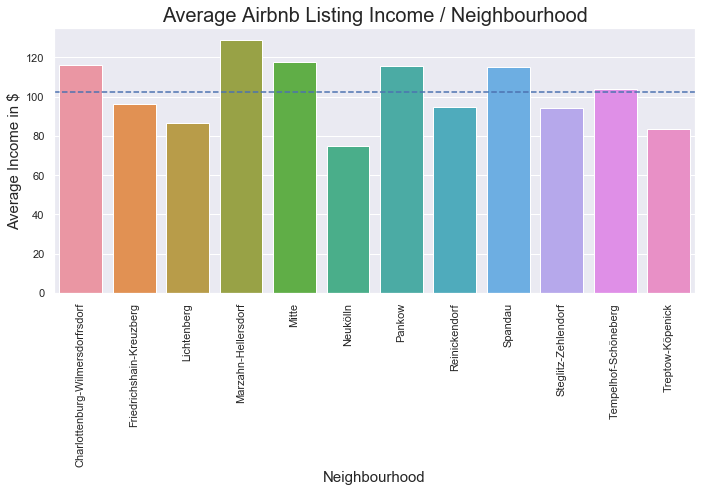

In [541]:
# Median listing income / neighbourhood
# Grouping functions
f = {"id":["count"], "income_per_month":["mean"], "bookings_per_month":["mean"]}

# Grouping data
income_neighbourhood = df_listings[["neighbourhood_group_cleansed", "id", "income_per_month", "bookings_per_month"]]
income_neighbourhood = income_neighbourhood.groupby("neighbourhood_group_cleansed", as_index=False).agg(f)
income_neighbourhood.columns = ["neighbourhood_group", "num_listings", "income_per_month", "bookings_per_month"]
income_neighbourhood = income_neighbourhood.sort_values("neighbourhood_group")

# Plot
plt.subplots(figsize=(10,6))
sns.set(style="darkgrid")
ax = sns.barplot(x="neighbourhood_group", y="income_per_month", data=income_neighbourhood)
plt.xticks(rotation=90);
plt.title("Average Airbnb Listing Income / Neighbourhood", fontsize=20)
plt.ylabel("Average Income in $", fontsize=15)
plt.xlabel("Neighbourhood", fontsize=15)
plt.tight_layout()

# Add mean as reference line
ax.axhline(income_neighbourhood["income_per_month"].mean(), ls='--');

In [535]:
# Load geojson object
# Source:
# https://data.technologiestiftung-berlin.de/dataset/bezirksgrenzen
berlin_hoods = os.path.join("../data/berlin_neighbourhood_groups.geojson")
geo_json_data = json.load(open(berlin_hoods))

In [536]:
# Create income dictionary
income_dict = income_neighbourhood.set_index("neighbourhood_group")["income_per_month"]
income_dict["Mitte"]

117.56451470530017

In [542]:
# Draw choropleth map (let folium determine the scale)
hood_map = folium.Map(location=[52.534537, 13.402557], zoom_start=10)
hood_map.choropleth(geo_data=geo_json_data, data=price_dict,
                    key_on="feature.properties.Gemeinde_name",
                    fill_color="OrRd", fill_opacity=0.7, line_opacity=0.2,
                    legend_name="Average Airbnb Listing Income Per Month in $")

hood_map.save("../data/airbnb_income_neighbourhoods.html")
hood_map